# Overall Planning for Mesa Debugging
- 1 [v] understanding the model, changing into infect goof + infect baad
- 2 [v] testing the code step by step and print stuff
- 3 [v] impliment the slider thing & test
- 4 [ ] make batch runner
- 5 [ ] make vis with Mesa
- 6 [ ] testing server and experiment making batch run server

## 1 - Completitive Linear Threshold Implimentation
impliment competitive linear threshold model proposed by He et al. [SIAM,2012](https://epubs.siam.org/doi/abs/10.1137/1.9781611972825.40)
The idea is: intead of imaginging information spread like disearse, imagine a network passing on +1s and -1s and hiiting designed threhold

In [1]:
from model import *

## 2 - competive linear threshold vis and debug
Denug with visualization and print out
I'm pretty sure my model is no problem

In [2]:
model = InfoSpread(num_nodes=40, avg_node_degree=5, rewire_prob=.3, initial_outbreak_size=2, threshold_fake = 2, threshold_real = -2)


In [3]:
model.run_model(5)

In [4]:
df = model.datacollector.get_model_vars_dataframe()
df

,Infected_fake,Infected_real
0,10,9
1,13,11
2,14,12
3,16,12
4,16,12
5,16,12


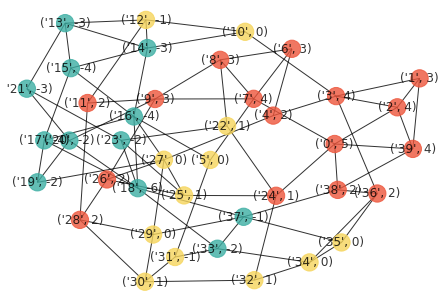

In [13]:
from visualization import *
a = vis(model)
a

In [12]:
model.step()

In [14]:
model.proportion_infected_fake(),model.proportion_infected_real()

(0.4, 0.3)

## 3 - transmission scale Implimentation

### Testing

In [ ]:
model = InfoSpread(num_nodes=40, avg_node_degree=5, rewire_prob=.3, initial_outbreak_size=2, threshold_fake = 2, threshold_real = -2, fake_p=0.8, real_p=0.5)


In [ ]:
model.run_model(5)

In [ ]:
df = model.datacollector.get_model_vars_dataframe()
df

In [ ]:
inf_count = []
state_color = []
for i in model.grid.get_cell_list_contents(model.G):
    inf_count.append(i.get_infected_neighbor_count())
    state = i.state
    if state == 1:
        state_color.append('#ED553B') # red
    elif state == -1:
        state_color.append('#3CAEA3') # green
    else:
        state_color.append('#F6D55C') #yellow       
        
inf_dic =  {}
for i in range(model.num_nodes):
    inf_dic.update({i:(str(i),inf_count[i])})

In [ ]:
nx.draw_kamada_kawai(model.G, node_size=300,node_color=state_color, labels=inf_dic, alpha = 0.8)    

## 2 - Testing Batch Run
### 2.1 Batch run improvements
These are additional functions to process th PANDAS document
- calculating the infection time (measured in steps it takes)
- calculating the infection percentage

In [ ]:
# Find the time it needed to infect the whole/part network
def find_last_increase (a):
    i = 0
    for i in range(len(a)-2):
        if a[i] != a[i+1]:
            i += 1
        else:
            return(i+1)
    return(i+1)

def calculate_infection_time(df):
    time = []
    for i in range(df.shape[0]):
        inf_data = df['infection_list'][i]['Infected'].values.tolist()
        infection_time = find_last_increase(inf_data)
        time.append(infection_time)
    return(time)

In [ ]:
#calculate percentage of infection
def find__final_infection_number (a):
    i = 0
    for i in range(len(a)-2):
        if a[i] != a[i+1]:
            i += 1
        else:
            return(a[i+1])
    return(a[i+1])

def calculate_total_infection(df):
    total_inf = []
    for i in range(df.shape[0]):
        inf_data = df['infection_list'][i]['Infected'].values.tolist()
        infection_num = find__final_infection_number(inf_data)
        total_inf.append(infection_num)
    return(total_inf)

### 2.2 Testing Batch Run with different average neighbors

In [ ]:
model = InfoSpread (num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2,)
#num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2
for i in range(100):
    model.step()

In [ ]:
model = InfoSpread (num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2,)
total_inf = [-1, 0] #buffer item
total_inf.append(number_infected(model))
while( total_inf[len(total_inf)-1] != total_inf[len(total_inf)-2] ):
    model.step()
    total_inf.append(number_infected(model))

In [ ]:
df = model.datacollector.get_model_vars_dataframe()
df

In [ ]:
#num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2
rewire_list = []
for i in range(21):
    rewire_list.append(round((i*0.05),3))
#rewire_list = [0, 0.1, 0.2, 0.3]

fixed_params = {"rewire_prob":0.15,
                "num_nodes": 80,
               "initial_outbreak_size" : 1,
                "threshold" : 2
                }
variable_params = {"avg_node_degree": range(2,20)
                  
                  }  #  {"rewire_prob": range(0.05, 1.0, 0.05)}

batch_run = BatchRunner(InfoSpread,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=10,
                        model_reporters={"infection_list": infected_list})
batch_run.run_all()

In [ ]:
run_data = batch_run.get_model_vars_dataframe()

In [ ]:
x = run_data['avg_node_degree'].values.tolist()
time = calculate_infection_time(run_data)
plt.plot(x,time,'o', color = '#3CAEA3', alpha = 0.3)
plt.xlabel("average node degree")
plt.ylabel("steps to infect network")
plt.title("control rewire prob = 0.15, treshoud = 2, outbreak size = 2,")
plt.xticks(x)
plt.show()

In [ ]:
x = run_data['avg_node_degree'].values.tolist()
inf = calculate_total_infection(run_data)
plt.plot(x,inf,'o', color = '#3CAEA3', alpha = 0.3)
plt.xlabel("average node degree")
plt.ylabel("total infection")
plt.title("control rewire prob = 0.15, treshoud = 2, outbreak size = 2,")
plt.xticks(x)
plt.show()

### 2.3 Testing batch run with changing rewireing factor

In [ ]:
#batch running test 2
from mesa.batchrunner import BatchRunner

#num_nodes=10, avg_node_degree=3, rewire_prob=.1, initial_outbreak_size=1, threshold = 2
rewire_list = []
for i in range(21):
    rewire_list.append(round((i*0.05),3))
#rewire_list = [0, 0.1, 0.2, 0.3]

fixed_params = {"num_nodes": 80,
               "avg_node_degree": 8,
               "initial_outbreak_size" : 1,
               "threshold" : 2}
variable_params = {"rewire_prob": rewire_list}  #  {"rewire_prob": drange(0.05, 1.0, 0.05)}

batch_run = BatchRunner(InfoSpread,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=10,
                        model_reporters={"infection_list": infected_list})
batch_run.run_all()

In [ ]:
run_data = batch_run.get_model_vars_dataframe()
#run_data

In [ ]:
import matplotlib.pyplot as plt
import numpy

In [ ]:

x = run_data['rewire_prob'].values.tolist()
time = calculate_infection_time(run_data)
plt.plot(x,time,'o', color = '#3CAEA3',alpha = 0.3)

In [ ]:
inf = calculate_total_infection(run_data)
plt.plot(x,inf,'o', color = '#ED553B', alpha = 0.3)

## 4 & 5 Defining variables, design and experiment with server

### 5.1 Server

In [ ]:
import math

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement
# from .model import InfoSpread, number_infected


def network_portrayal(G):
    # The model ensures there is always 1 agent per node

    def node_color(agent):
        if agent.state == "infected":
            return "#FF0000"
        elif agent.state == 'susceptible':
            return "#008000"

    def edge_color(agent1, agent2):
        if "resistant" in (agent1.state, agent2.state):
            return "#000000"
        return "#e8e8e8"

    def edge_width(agent1, agent2):
        if "resistant" in (agent1.state, agent2.state):
            return 3
        return 2

    def get_agents(source, target):
        return G.nodes[source]["agent"][0], G.nodes[target]["agent"][0]

    portrayal = dict()
    portrayal["nodes"] = [
        {
            "size": 6,
            "color": node_color(agents[0]),
            "tooltip": "id: {}<br>state: {}".format(
                agents[0].unique_id, agents[0].state
            ),
        }
        for (_, agents) in G.nodes.data("agent")
    ]

    portrayal["edges"] = [
        {
            "source": source,
            "target": target,
            "color": edge_color(*get_agents(source, target)),
            "width": edge_width(*get_agents(source, target)),
        }
        for (source, target) in G.edges
    ]

    return portrayal


network = NetworkModule(network_portrayal, 500, 500, library="d3")
chart = ChartModule(
    [
        {"Label": "Infected", "Color": "#FF0000"},
        {"Label": "Susceptible", "Color": "#008000"},
        {"Label": "Resistant", "Color": "#808080"},
    ]
)


class MyTextElement(TextElement):
    def render(self, model):
        ratio = model.proportion_infected()
        ratio_text = "&infin;" if ratio is math.inf else "{0:.2f}".format(ratio)
        infected_text = number_infected(model)

        return "Proportion Infected: {}<br>Infected: {}".format(
            ratio_text, infected_text
        )


model_params = {
    "num_nodes": UserSettableParameter(
        "slider",
        "Number of agents",
        10,
        10,
        100,
        1,
        description="Choose how many agents to include in the model",
    ),
    
    "avg_node_degree": UserSettableParameter(
        "slider", "Avg Node Degree", 4, 2, 8, 2, description="Avg Node Degree"
    ),
    
    "rewire_prob": UserSettableParameter(
        "slider",
        "Rewire Probability",
        .1,
        0,
        1,
        .05,
        description = "Rewire probability"),
    
    "initial_outbreak_size": UserSettableParameter(
        "slider",
        "Initial Outbreak Size",
        1,
        1,
        5,
        1,
        description="Initial Outbreak Size",
    ),
    "threshold": UserSettableParameter(
        "slider",
        "Neighbor Threshold",
        2,
        1,
        5,
        1,
        description="Neighbor Threshold",
    )
}

server = ModularServer(
    InfoSpread, [network, MyTextElement(), chart], "Complex Contagion Model", model_params
)
server.port = 8521



In [ ]:
#testing visualizing charts in a server
from mesa.visualization.modules import ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from model import InfoSpread, number_infected
from mesa.visualization.modules import TextElement




In [ ]:
class MyTextElement(TextElement):
    def render(self, model):
        ratio = model.proportion_infected()
        ratio_text = "&infin;" if ratio is math.inf else "{0:.2f}".format(ratio)
        infected_text = number_infected(model)

        return "Proportion Infected: {}<br>Infected: {}".format(
            ratio_text, infected_text
        )

In [ ]:
chart = ChartModule([
        {"Label": "Infected", "Color": "#FF0000"},
        {"Label": "Susceptible", "Color": "#008000"},
        {"Label": "Resistant", "Color": "#808080"},
    ])

server = ModularServer(InfoSpread,
                       [ MyTextElement(), chart],
                       "Complex Comtagion Batch Run")

In [ ]:
server.port = 8521 # The default
server.launch()

## 6 - Impliment one intervention


## Legacy code

In [ ]:
#define a better range function
def drange(x, y, jump):
  while x < y:
    yield round(float(x),2)
    x += jump